# Import requirements

In [61]:
import numpy as np
import pandas as pd
import os
import itertools
from __future__ import division
import matplotlib.pyplot as plt
import matplotlib as mpl
import operator
from scipy import stats
from collections import Counter
import math
%matplotlib inline

In [3]:
from sklearn.lda import LDA
from scipy import stats
import matplotlib as mpl

# Import data

In [4]:
DF = pd.read_csv('/Users/greg/Desktop/FullNeuroIllumina/MergedData/NGS_GDS_abundance.csv')

# trim columns
C = ['Patient','Visit','DateOfVisit','Age','Gender','ART','VL','iVL','pVL',
     'CD4','iCD4','nCD4','CD8','iCD8','nCD8','TMHDS','VisitDate','GDS','Prot', 
     'AAPos','Coverage','A','R','N','D','C','Q','E','G','H','I','L','K','M',
     'F','P','S','T','W','Y','V']
DF = DF[C]
print DF.shape
DF.head()

(5608, 41)


,Patient,Visit,DateOfVisit,Age,Gender,ART,VL,iVL,pVL,CD4,...,L,K,M,F,P,S,T,W,Y,V
0,A0001,R09,2014-11-10,59,Male,on,20,987,987,797,...,0.006934,0.001695,0.565052,0.000026,0,0.000848,0.000128,0.416637,0,0.000205
1,A0010,R08,2014-11-12,59,Male,on,20,50,470,1167,...,0.005848,0.005848,0.584795,0.000000,0,0.000000,0.000000,0.403509,0,0.000000
2,A0013,R09,2014-11-10,68,Male,on,20,144,39373,771,...,0.001661,0.004983,0.282392,0.000000,0,0.001661,0.000000,0.209302,0,0.000000
3,A0019,R12,2015-02-02,46,Female,on,20,99,164020,1130,...,0.008081,0.003367,0.526599,0.000000,0,0.001347,0.000673,0.452525,0,0.000000
4,A0026,R09,2015-04-30,55,Male,on,67859,100000,100000,137,...,0.008982,0.000000,0.589820,0.000000,0,0.002994,0.000000,0.389222,0,0.000000


# Functions

In [104]:
# will need to adjust for 101 amino acids

def slice_position(df, pos):
    m = df['AAPos'] == pos
    sliced_df = df[m]
    return sliced_df

def reformat_section(df):
    '''Must be a dataframe containing only 1 position'''
    pos = str(int(list(df.AAPos)[0]))
    AAs = ['A','R','N','D','C','Q','E','G','H','I',
           'L','K','M','F','P','S','T','W','Y','V']
    newnames_dict = {}
    for item in AAs:
        newnames_dict[item]= pos+item
    df_renamed = df.rename(columns = newnames_dict)
    df_renamed.drop(['AAPos','Coverage', 'Prot', 'DateOfVisit', 'VisitDate'], axis=1, inplace=True)
    return df_renamed

def bhatta(x1, x2, nbins):    
    global_min = min([min(x1), min(x2)])
    global_max = max([max(x1), max(x2)])
    h1, b1 = np.histogram(x1, bins=nbins, range=(global_min, global_max))
    h2, b2 = np.histogram(x2, bins=nbins, range=(global_min, global_max))    
    h1_ = h1/sum(h1)
    h2_ = h2/sum(h2)
    coeff = 0;
    for i in range(len(h1_)):
        coeff += math.sqrt(h1_[i]*h2_[i])
    distance = -np.log(coeff)
    return coeff, distance

def median_diff(x1, x2):    
    med1 = np.median(x1)
    med2 = np.median(x2)
    diff = abs(med2-med1)
    return diff

# Script

In [6]:
tat_length = 101
on_columns = ['Patient', 'Visit', 'Age', 'Gender', 'ART', 'VL','iVL', 'pVL', 'CD4', 'iCD4', 
              'nCD4', 'CD8', 'iCD8', 'nCD8', 'TMHDS', 'GDS']

start_df = slice_position(DF, 1)
sklearn_df = reformat_section(start_df)
for i in range(2,tat_length+1):
    pos_df = slice_position(DF, i)
    pos_df2 = reformat_section(pos_df)
    sklearn_df = pd.merge(sklearn_df, pos_df2,
               left_on=on_columns,
               right_on=on_columns,
               how='outer')    

# deak with Nans
sklearn_df.fillna(sklearn_df.mean(), inplace=True)

# set y threshold
sklearn_df['GDS_Threshold'] = sklearn_df['GDS'] > 0.5
sklearn_df['GDS_Threshold'] = sklearn_df['GDS_Threshold'].astype(int)
print sklearn_df.shape
sklearn_df.head()

(72, 2036)


,Patient,Visit,Age,Gender,ART,VL,iVL,pVL,CD4,iCD4,...,101L,101K,101M,101F,101P,101S,101T,101W,101Y,101V
0,A0001,R09,59,Male,on,20,987,987,797,400,...,0.000407,0.000000,0,0,0.000081,0.000244,0.000000,0.000163,0,0.00122
1,A0010,R08,59,Male,on,20,50,470,1167,448,...,0.000000,0.000757,0,0,0.000000,0.004542,0.000000,0.000000,0,0.00000
2,A0013,R09,68,Male,on,20,144,39373,771,564,...,0.002552,0.000000,0,0,0.000150,0.001201,0.000000,0.000000,0,0.00000
3,A0019,R12,46,Female,on,20,99,164020,1130,398,...,0.000000,0.000000,0,0,0.989574,0.000000,0.001813,0.000000,0,0.00000
4,A0026,R09,55,Male,on,67859,100000,100000,137,36,...,0.003805,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,0,0.00000


# Iterative 1

In [49]:
def getgroups(X):
    all_groups = []
    groupidx = [i for i in range(0,len(X.columns)+20,20)]
    for i in range(len(groupidx)-1):
        current_group = list(X.columns[groupidx[i]:groupidx[i+1]])
        all_groups.append(current_group)
    return all_groups

def DF_to_arrays(X):
    Xmatrix1 = X.as_matrix()   
    model = LDA(n_components=2, shrinkage=None)
    X_transform = model.fit(Xmatrix1, y).transform(Xmatrix1)
    x1 = X_transform[y == 0, 0]
    x2 = X_transform[y == 1, 0]
    return x1,x2

In [75]:
y = np.ravel(sklearn_df['GDS_Threshold'])
drop_cols = on_columns + ['GDS_Threshold']
X = sklearn_df.drop(drop_cols, axis=1)
AAs = ['A','R','N','D','C','Q','E','G','H','I',
       'L','K','M','F','P','S','T','W','Y','V']

ranker_dict = {'Position':[], 'Distance':[]}

for i in range(1,101):
    # parent matrix from X - get distance metric
    x1, x2 = DF_to_arrays(X)
    coeff1, distance1 = bhatta(x1, x2, 10)
    
    # consider all positions
    allgroups = getgroups(X)
    distances = []
    for g in allgroups:
        X2 = X.drop(g, axis=1)
        x3, x4 = DF_to_arrays(X2)
        coeff2, distance2 = bhatta(x3, x4, 10)
        distances.append(distance2)
        
    #evaluate the best
    min_index, min_value = min(enumerate(distances), key=operator.itemgetter(1))
    dlist = allgroups[min_index]
    
    #append to dictionary
    ranker_dict['Distance'].append(min_value)
    ranker_dict['Position'].append(int(dlist[0].replace('A','')))
    
    #drop position
    X.drop(dlist, axis=1, inplace=True)

In [86]:
pd.DataFrame(ranker_dict).head()

,Distance,Position
0,0.817517,101
1,0.625241,91
2,0.614113,72
3,0.614113,1
4,0.606592,98


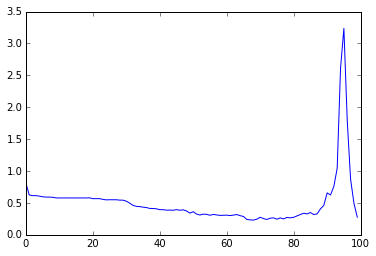

In [84]:
plt.plot(ranker_dict['Distance'])
plt.show()
#wtf is this all about?

# Iterative build up

In [106]:
y = np.ravel(sklearn_df['GDS_Threshold'])
drop_cols = on_columns + ['GDS_Threshold']
X = sklearn_df.drop(drop_cols, axis=1)
AAs = ['A','R','N','D','C','Q','E','G','H','I',
       'L','K','M','F','P','S','T','W','Y','V']

ranker_dict = {'Position':[], 'Distance':[]}

allgroups = getgroups(X)
best_groups = []
best_positions = []
for i in range(1,101):
    print i    
    distances = []
    for g in allgroups:
        X2 = X[best_groups + g]
        x1, x2 = DF_to_arrays(X2)
        #coeff, distance = bhatta(x1, x2, 10)
        diff = median_diff(x1, x2)
        distances.append(diff)

    max_index, max_value = max(enumerate(distances), key=operator.itemgetter(1))
    dlist = allgroups[max_index]
    pos = int(dlist[0].replace('A',''))
    best_positions.append(pos)
    best_groups = best_groups + dlist
    allgroups.remove(dlist)
    
    print max_value
    print best_positions
    print ''

1
1.11513339989
[33]

2
3.46671346616
[33, 2]

3
6.2735999781
[33, 2, 77]

4
76.7477022847
[33, 2, 77, 21]

5
37.0354229368
[33, 2, 77, 21, 68]

6
35.5789834997
[33, 2, 77, 21, 68, 10]

7
35.0164080989
[33, 2, 77, 21, 68, 10, 69]

8
34.5355374796
[33, 2, 77, 21, 68, 10, 69, 36]

9
34.4034700993
[33, 2, 77, 21, 68, 10, 69, 36, 4]

10
34.1041265867
[33, 2, 77, 21, 68, 10, 69, 36, 4, 54]

11
33.9014908
[33, 2, 77, 21, 68, 10, 69, 36, 4, 54, 1]

12
33.4565225933
[33, 2, 77, 21, 68, 10, 69, 36, 4, 54, 1, 11]

13
32.9411420889
[33, 2, 77, 21, 68, 10, 69, 36, 4, 54, 1, 11, 65]

14
32.3741001515
[33, 2, 77, 21, 68, 10, 69, 36, 4, 54, 1, 11, 65, 14]

15
31.8817355041
[33, 2, 77, 21, 68, 10, 69, 36, 4, 54, 1, 11, 65, 14, 12]

16
31.4943381799
[33, 2, 77, 21, 68, 10, 69, 36, 4, 54, 1, 11, 65, 14, 12, 47]

17
31.1532815408
[33, 2, 77, 21, 68, 10, 69, 36, 4, 54, 1, 11, 65, 14, 12, 47, 31]

18
30.9349483786
[33, 2, 77, 21, 68, 10, 69, 36, 4, 54, 1, 11, 65, 14, 12, 47, 31, 28]

19
30.7353831907
[33, 

In [ ]:
y = np.ravel(sklearn_df['GDS_Threshold'])
drop_cols = on_columns + ['GDS_Threshold']
X = sklearn_df.drop(drop_cols, axis=1)
AAs = ['A','R','N','D','C','Q','E','G','H','I',
       'L','K','M','F','P','S','T','W','Y','V']

ranker_dict = {'Position':[], 'Distance':[]}

for i in range(1,101):
    # parent matrix from X - get distance metric
    x1, x2 = DF_to_arrays(X)
    coeff1, distance1 = bhatta(x1, x2, 10)
    
    # consider all positions
    allgroups = getgroups(X)
    distances = []
    for g in allgroups:
        X2 = X.drop(g, axis=1)
        x3, x4 = DF_to_arrays(X2)
        coeff2, distance2 = bhatta(x3, x4, 10)
        distances.append(distance2)
        
    #evaluate the best
    min_index, min_value = min(enumerate(distances), key=operator.itemgetter(1))
    dlist = allgroups[min_index]
    
    #append to dictionary
    ranker_dict['Distance'].append(min_value)
    ranker_dict['Position'].append(int(dlist[0].replace('A','')))
    
    #drop position
    X.drop(dlist, axis=1, inplace=True)

In [85]:
AAs = ['A','R','N','D','C','Q','E','G','H','I',
       'L','K','M','F','P','S','T','W','Y','V']
y = np.ravel(sklearn_df['GDS_Threshold'])
X = sklearn_df.drop(drop_cols, axis=1)

bhatta_dict = {'Position':[], 'Coefficient':[], 'Distance':[]}

for i in range(101):
    pos_cols = []
    n = i+1
    
    for aa in AAs:
        pos_cols.append(str(n)+aa)
                   
    Xdf = X[pos_cols]    
    x1, x2 = DF_to_arrays(Xdf)
    
    coeff, distance = bhatta(x1,x2,10)
    bhatta_dict['Position'].append(n)
    bhatta_dict['Coefficient'].append(coeff)
    bhatta_dict['Distance'].append(distance)
    #lda_plot(x1,x2)
    
bhatta_df = pd.DataFrame(bhatta_dict)
bhatta_df.sort_values(by='Distance', inplace=True, ascending=False)
bhatta_df.head(20)

,Coefficient,Distance,Position
12,0.541489,0.613433,13
76,0.595117,0.518997,77
68,0.627058,0.466716,69
54,0.632555,0.457989,55
32,0.633554,0.456411,33
11,0.639367,0.447277,12
56,0.645248,0.438120,57
17,0.650514,0.429992,18
90,0.658935,0.417131,91
13,0.662266,0.412088,14
